# Evaluating a Manufacturing Process

## 1. 📌 Project Overview
- **Brief Description**:  
  The goal of the project is to analyze historical manufacturing data to define an acceptable range and identify any points in the process that fall outside of this range and therefore require adjustments. This methodical
  approach, known as statistical process control (SPC), is designed to ensure that the manufacturing process consistently delivers high-quality parts.
- **Key Questions**:  
  - To evaluate whether the manufacturing process (specifically the height of manufactured parts) is within statistical control limits.
  - To identify operators who are producing a disproportionately high number of out of the range parts, implying that their machines might be malfunctioning or they may need retraining.

## 2. 🛠️ Data Preparation
- **Load and Preview Dataset**:

In [27]:
-- Preview of the dataset
SELECT *
FROM manufacturing_parts
LIMIT 5

,item_no,length,width,height,operator
0,1,102.67,49.53,19.69,Op-1
1,2,102.50,51.42,19.63,Op-1
2,3,95.37,52.25,21.51,Op-1
3,4,94.77,49.24,18.60,Op-1
4,5,104.26,47.90,19.46,Op-1


- **Key Variables**:  
  The data is available in the `manufacturing_parts` table which has the following fields and data types: 

    - `item_no`: the item number, `BIGINT`
    - `length`: the length of the item made, `DOUBLE PRECISION` 
    - `width`: the width of the item made, `DOUBLE PRECISION`
    - `height`: the height of the item made, `DOUBLE PRECISION` 
    - `operator`: the operating machine, `TEXT`

## 3. 📊 Analysis & Visualizations
- **Insight 1: Create an alert that flags whether the height of a part is within the control limits for each operator.** 
    - SQL query calculates the upper control limit (ucl) and lower control limit (lcl) based on the average height and standard deviation of the last 5 heights for each operator.
      - If the height is outside these limits, it sets an alert flag to TRUE; otherwise, it sets it to FALSE.
      - The innermost subquery (a) calculates the row number, height, average height, and standard deviation of height for the last 5 rows for each operator.
      - The middle subquery (b) calculates the control limits (ucl and lcl) using the average height and standard deviation.
      - The outer query flags whether the height is outside the control limits.
      - The query only considers rows where there are at least 5 preceding rows (row_number >= 5).

In [28]:
-- Flag whether the height of a part is within the control limits 
SELECT
	b.*,
	CASE 
		WHEN b.height NOT BETWEEN b.lcl AND b.ucl THEN TRUE
		ELSE FALSE 
	END AS alert
FROM (
	SELECT
		a.*, 
		a.avg_height + 3 * a.stddev_height/SQRT(5) AS ucl, 
		a.avg_height - 3 * a.stddev_height/SQRT(5) AS lcl  
	FROM (
		SELECT 
			operator,
			ROW_NUMBER() OVER w AS row_number, 
			height, 
			AVG(height) OVER w AS avg_height, 
			STDDEV(height) OVER w AS stddev_height
		FROM manufacturing_parts 
		WINDOW w AS (
			PARTITION BY operator 
			ORDER BY item_no 
			ROWS BETWEEN 4 PRECEDING AND CURRENT ROW
		)
	) AS a
	WHERE a.row_number >= 5
) AS b;

,operator,row_number,height,avg_height,stddev_height,ucl,lcl,alert
0,Op-1,5,19.46,19.778,1.062812,21.203912,18.352088,False
1,Op-1,6,20.36,19.912,1.090812,21.375477,18.448523,False
2,Op-1,7,20.22,20.030,1.084574,21.485108,18.574892,False
3,Op-1,8,21.03,19.934,0.931225,21.183369,18.684631,False
4,Op-1,9,19.78,20.170,0.598832,20.973418,19.366582,False
...,...,...,...,...,...,...,...,...
415,Op-9,31,19.01,18.904,0.203052,19.176422,18.631578,False
416,Op-9,32,18.57,18.864,0.250260,19.199759,18.528241,False
417,Op-9,33,20.91,19.266,0.952276,20.543613,17.988387,True
418,Op-9,34,21.24,19.678,1.291112,21.410208,17.945792,False


## Visualization 1 Setup:
    - The query result is stored in the `df_alerts` data frame. This dataset includes: `operator`, `row_number` (tracking time/order per operator), `height`, `avg_height`, `stddev_height`, `ucl`, `lcl`, `alert` flag.
    - 📈 Control Chart (aka Shewhart Chart) components:
    - X-axis: row_number
    - Y-axis: height
    - Lines: `UCL` (Upper Control Limit), `LCL` (Lower Control Limit), `Mean` (avg_height)
    - Points: Color-coded by `alert` (**red** for True, **blue** for False)
    - Option: Separate chart per operator using subplots or filters

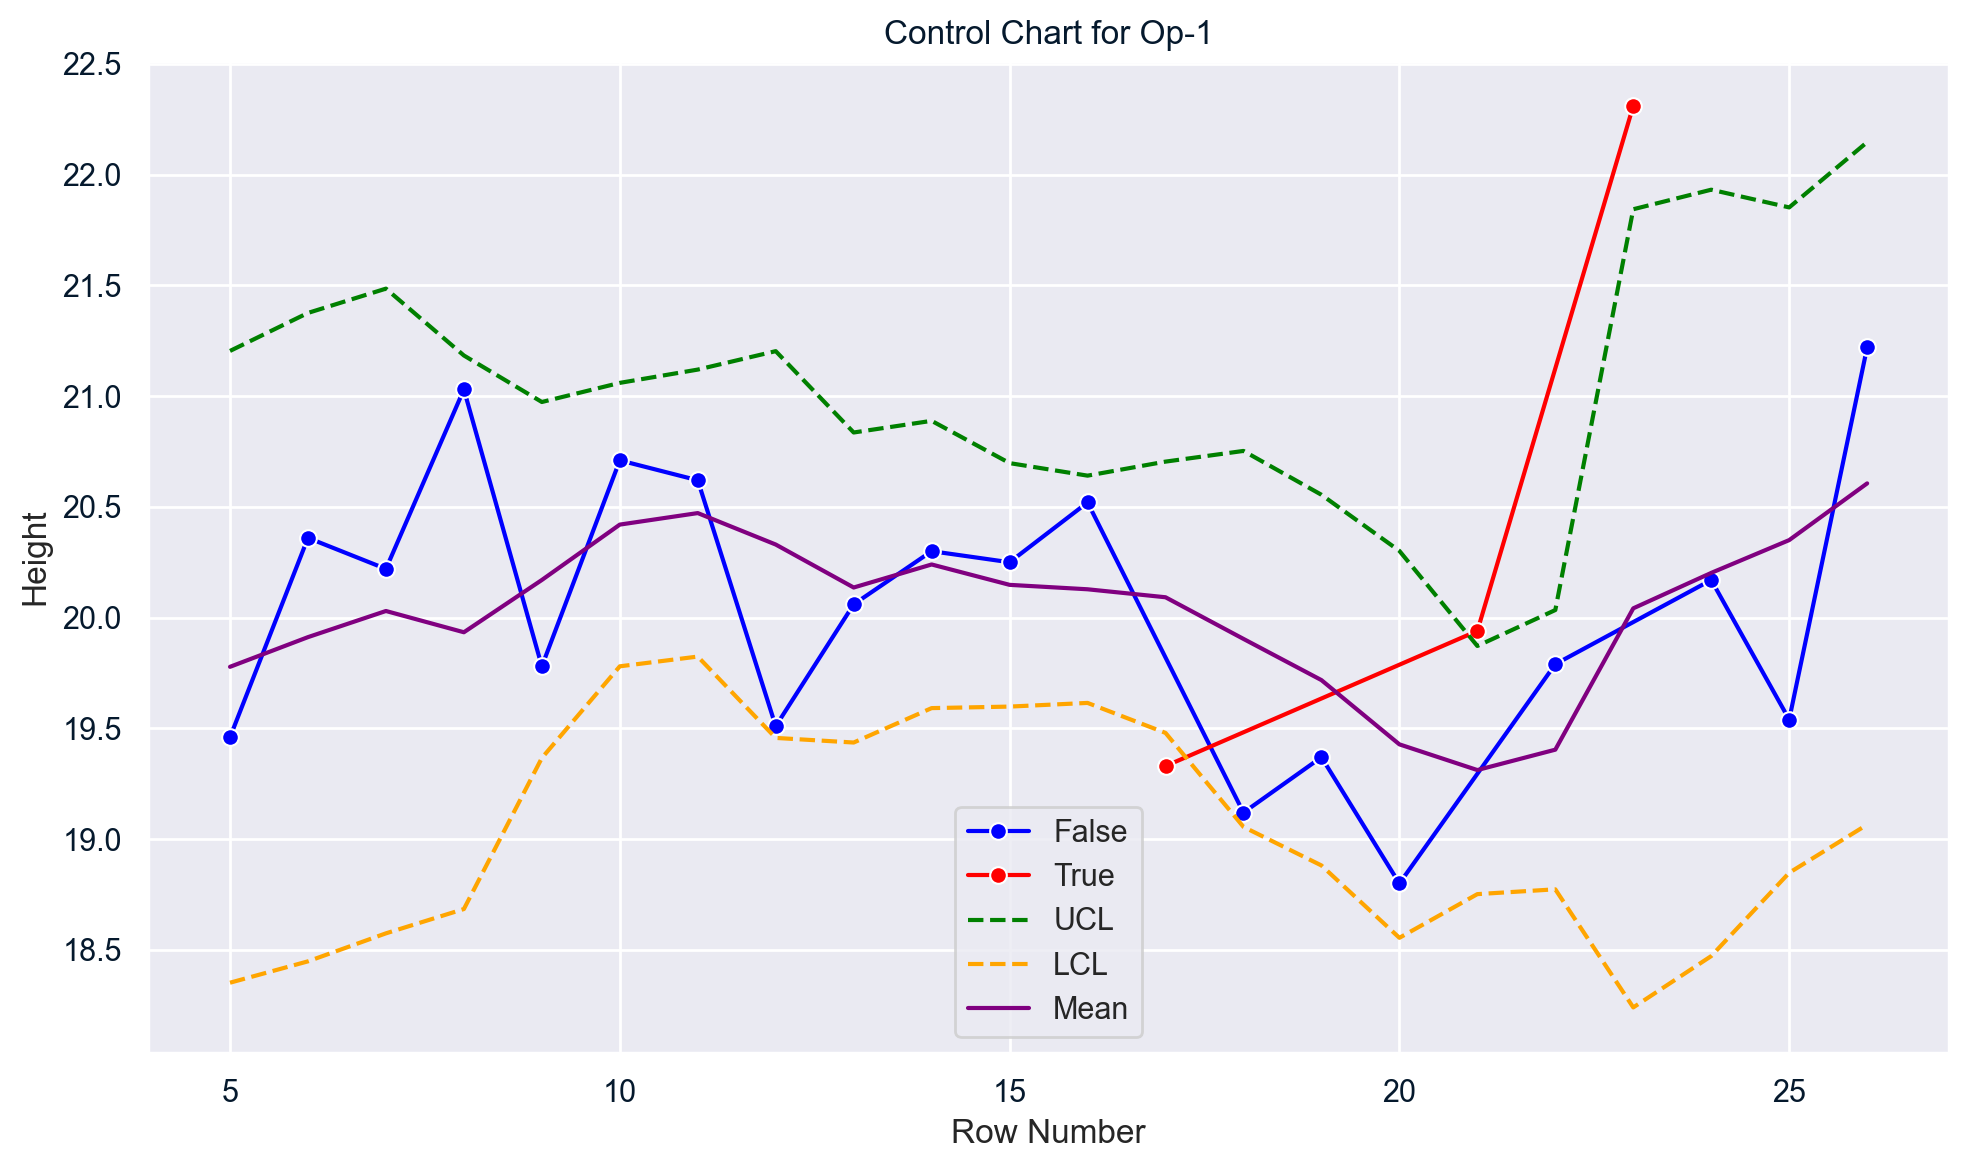

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = "darkgrid")

# Filter data for operator 'Op-1'
df_op1 = df_alerts[df_alerts['operator'] == 'Op-1']

# Create a figure and axis
plt.figure(figsize = (10, 6))

# Plot the height values
sns.lineplot(x = "row_number", y = "height", hue = "alert", palette = {True: "red", False: "blue"}, data = df_op1, marker = "o")

# Plot the UCL, LCL, and Mean lines
plt.plot(df_op1['row_number'], df_op1['ucl'], color = 'green', linestyle = '--', label = 'UCL')
plt.plot(df_op1['row_number'], df_op1['lcl'], color = 'orange', linestyle = '--', label = 'LCL')
plt.plot(df_op1['row_number'], df_op1['avg_height'], color = 'purple', linestyle = '-', label = 'Mean')

# Styling
plt.title('Control Chart for Op-1', fontsize = 12)
plt.xlabel('Row Number', fontsize = 12)
plt.ylabel('Height', fontsize = 12)
plt.legend()
plt.tight_layout()
plt.show()

- **Visualization 1 Analysis:**
    - The plotted control chart is defferent form a classic control chart where `UCL,` `LCL` and `Mean` are typically horizontal lines, representing control thresholds.
    - The plotte chart uses rolling UCL/LCL/mean values, which vary row by row.
    - This is technically accurate from the SQL output (because it was based on a moving window).

- **Visualization 1 Alternative (Fixed Control Limits):**
    - To visualize process control stability over time, used fixed control limits calculated from the entire data sample.
    - Computed overall `mean` height for operator 'Op-1', overall `stddev` for height, `UCL,` and `LCL`.
    - Used fixed control limits for plotting; rolling values for calculation and flagging.

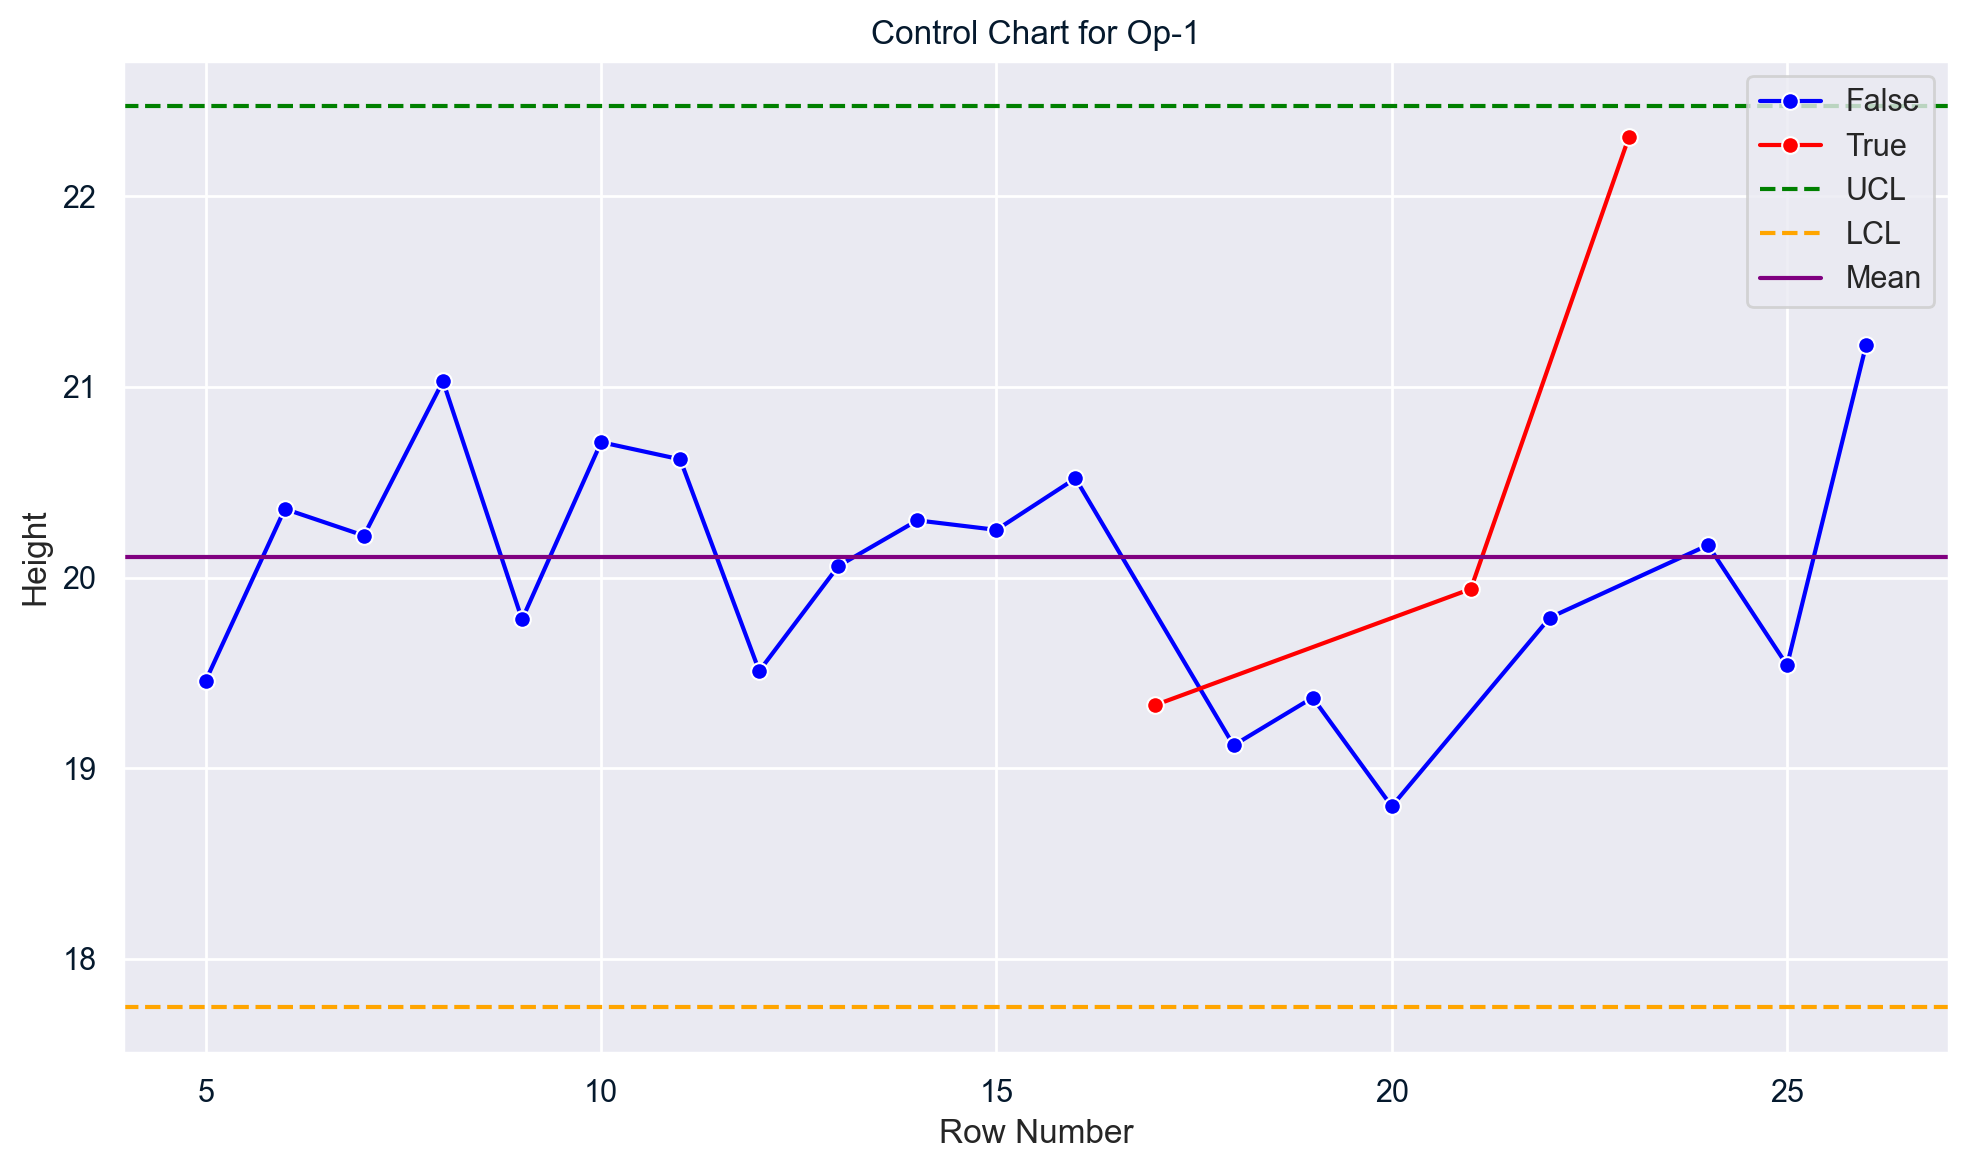

In [30]:
# Filter data for operator 'Op-1'
df_op1 = df_alerts[df_alerts['operator'] == 'Op-1']

# Calculate overall stats
mean_height = df_op1['height'].mean()
stddev_height = df_op1['height'].std()
ucl = mean_height + 3 * stddev_height
lcl = mean_height - 3 * stddev_height

# Create control chart
plt.figure(figsize = (10, 6))

# Plot height values over row_number, color-coded by alert
sns.lineplot(x = "row_number", y = "height", hue = "alert", palette = {True: "red", False: "blue"}, data = df_op1, marker = "o")

# Plot horizontal UCL, LCL, and mean lines
plt.axhline(y = ucl, color = 'green', linestyle = '--', label = 'UCL')
plt.axhline(y = lcl, color = 'orange', linestyle = '--', label = 'LCL')
plt.axhline(y = mean_height, color = 'purple', linestyle = '-', label = 'Mean')

# Styling
plt.title('Control Chart for Op-1', fontsize = 12)
plt.xlabel('Row Number', fontsize = 12)
plt.ylabel('Height', fontsize = 12)
plt.legend()
plt.tight_layout()
plt.show()


- **Visualization 1 (Dynamic Control Limits):**
    - In the initial version of the control chart, I chose to use dynamic (rolling) control limits based on a moving window of five parts. This approach aligns with short-term statistical process control (SPC) practices
      where local variation is monitored closely in real time. The dynamic limits reflect the immediate operating conditions of the machine and operator, making them more sensitive to shifts in the process and potentially
      catching subtle trends that fixed thresholds may miss.
    - While traditional control charts use fixed global limits for overall process stability analysis, the dynamic version is more useful during early monitoring, tuning, or when the process is expected to evolve - such as
      during new operator training or after maintenance. For completeness and comparison, I’ve also included a classic control chart with fixed limits calculated from the overall mean and standard deviation.

## 4.1 💬 Insight 1 Reflections
- **Most Common Pattern**:
    - The most common pattern observed in the dynamic control chart is the frequent adjustment of control limits. This is due to the rolling window approach, which recalculates the limits based on the most recent five parts. This pattern indicates that the process is being closely monitored and is responsive to short-term variations.

- **Unexpected Pattern**:
    - An unexpected pattern is the occasional false alerts generated by the dynamic control limits. Since the limits are more sensitive to immediate changes, minor fluctuations that are not indicative of a real process shift can trigger alerts. This can lead to overreacting to normal process noise.

- **Real-World Meaning**:
    - In a real-world manufacturing environment, the use of dynamic control limits can be particularly beneficial during periods of change, such as new operator training or post-maintenance. It allows for immediate detection of deviations and quick corrective actions. However, it also requires operators to be aware of the potential for false alerts and to use their judgment in interpreting the data. The inclusion of a classic control chart with fixed limits provides a baseline for overall process stability, ensuring that long-term trends are not overlooked.

- **Insight 2: Identify operators whose alert rate is above average — indicating systemic issues beyond expected variation.** 
    - SQL query is designed to identify and analyze height alerts for manufacturing parts based on statistical control limits.
      - It consists of several Common Table Expressions (CTEs) and a final SELECT statement.
      - The CTE `alerts` calculates whether the height of a part is outside the control limits (UCL and LCL) for each operator.
      - The CTE `operator_alerts` counts the number of alerts for each operator.
      - The CTE `alert_stats` calculates the total number of alerts, the alert rate for each operator, and the average alert rate.
      - The final SELECT statement selects the operator, alert count, alert rate, average alert rate, and whether the alert rate is above average.

In [33]:
WITH alerts AS (
	SELECT
	b.*,
	CASE WHEN b.height NOT BETWEEN b.lcl AND b.ucl
		 THEN TRUE
		 ELSE FALSE
		 END AS alert
	FROM (
		SELECT
			a.*, 
			a.avg_height + 3*a.stddev_height/SQRT(5) AS ucl, 
			a.avg_height - 3*a.stddev_height/SQRT(5) AS lcl  
		FROM (
			SELECT
				item_no,
				operator,
				ROW_NUMBER() OVER w AS row_number, 
				height, 
				AVG(height) OVER w AS avg_height, 
				STDDEV(height) OVER w AS stddev_height
			FROM manufacturing_parts 
			WINDOW w AS (
				PARTITION BY operator 
				ORDER BY item_no 
				ROWS BETWEEN 4 PRECEDING AND CURRENT ROW
			)
		) AS a
		WHERE a.row_number >= 5
	) AS b
),
operator_alerts AS (
    SELECT
        operator,
        COUNT(*) AS alert_count
    FROM alerts
    WHERE alert = TRUE
    GROUP BY operator
),
alert_stats AS (
	SELECT
		operator,
		alert_count,
		SUM(alert_count) OVER() AS total_alerts,
		alert_count / NULLIF(SUM(alert_count) OVER()::FLOAT, 0) AS alert_rate,
		1 / (COUNT(operator) OVER())::FLOAT AS avg_alert_rate
	FROM operator_alerts
)
SELECT
	operator,
	alert_count,
	alert_rate,
	avg_alert_rate,
	alert_rate > avg_alert_rate AS above_average
FROM alert_stats
ORDER BY alert_count DESC;

,operator,alert_count,alert_rate,avg_alert_rate,above_average
0,Op-5,6,0.105263,0.05,True
1,Op-14,5,0.087719,0.05,True
2,Op-4,4,0.070175,0.05,True
3,Op-16,4,0.070175,0.05,True
4,Op-2,4,0.070175,0.05,True
5,Op-7,4,0.070175,0.05,True
6,Op-1,3,0.052632,0.05,True
7,Op-10,3,0.052632,0.05,True
8,Op-13,3,0.052632,0.05,True
9,Op-20,3,0.052632,0.05,True


## Visualization 2 Setup:
    - The query result is stored in the `df_operator_alerts` data frame. This dataset includes: `operator`, `alert_count`, `alert_rate`, `avg_alert_rate`, `above_average` (boolean flag).
    - 📊 Bar Chart: alert_count by operator
    - Highlights `above_average` operators in a different color based on the above_average flag

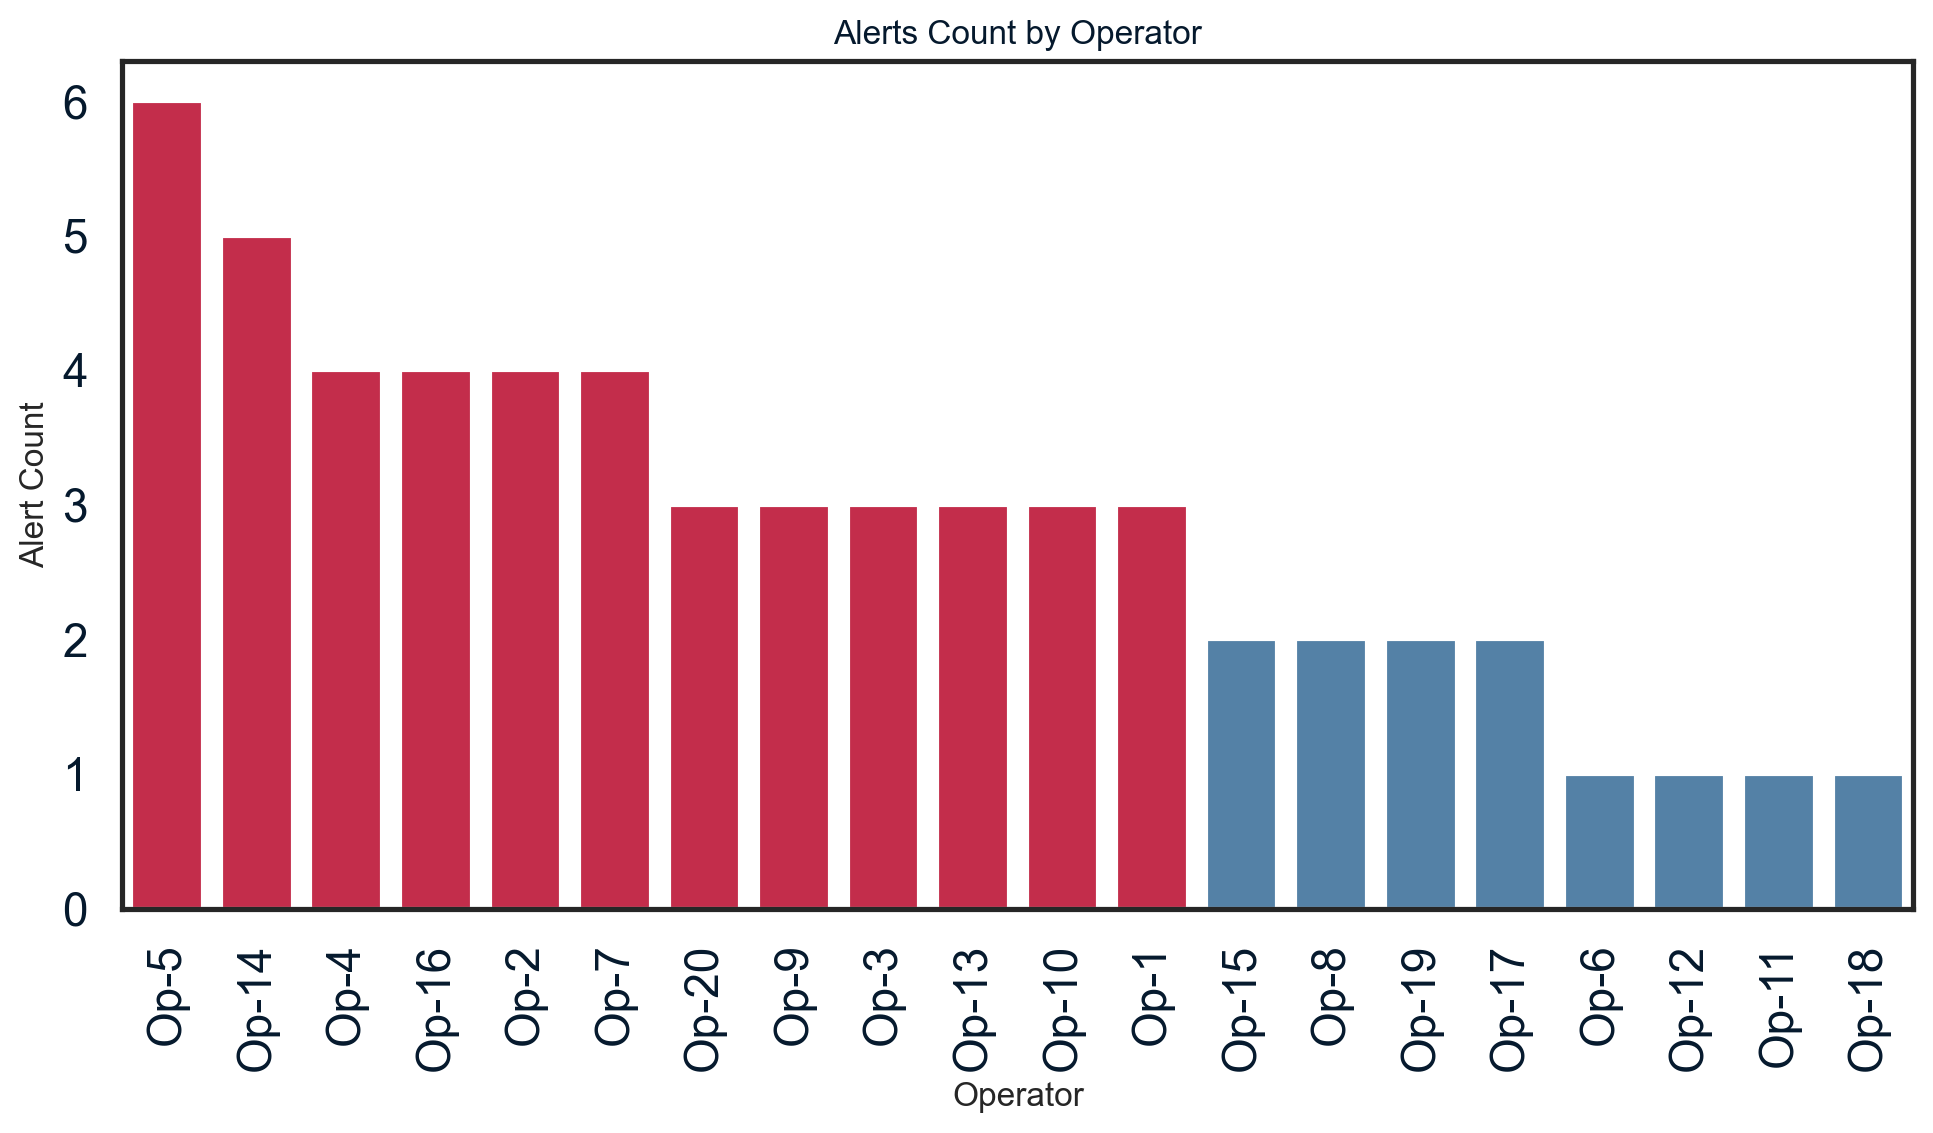

In [38]:
# Set theme
sns.set_theme(style = "white", context = "talk")

# Sort data so bar order matches color order
df_sorted = df_operator_alerts.sort_values('alert_count', ascending = False).copy()

# Assign color based on above_average flag
df_sorted['bar_color'] = df_sorted['above_average'].map({True: 'crimson', False: 'steelblue'})

# Plot
plt.figure(figsize = (10, 6))
sns.barplot(
    data = df_sorted,
    x = 'operator',
    y = 'alert_count',
    palette = df_sorted['bar_color'].tolist()
)

# Styling
plt.title('Alerts Count by Operator', fontsize = 12)
plt.ylabel('Alert Count', fontsize = 12)
plt.xlabel('Operator', fontsize = 12)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()


## 4.2 💬 Insight 2 Reflections
- **Most Common Pattern**:
    - The most common pattern observed is the variation in alert counts among different operators. This indicates that some operators are more prone to generating alerts than others. The `above_average` flag helps in identifying which operators have alert counts higher than the average, highlighting those who may need additional training or support.

- **Unexpected Pattern**:
    - An unexpected pattern is the presence of operators with high alert rates but low alert counts. This could be due to a small number of observations for those operators, making their alert rate appear disproportionately high. This pattern suggests that alert rate alone may not be a reliable indicator of performance without considering the context of the number of observations.

- **Real-World Meaning**:
    - In a real-world manufacturing environment, this insight can be used to identify operators who consistently perform above or below average in terms of alert generation. This information can be valuable for targeted training and process improvement initiatives.

## Visualization 3 Setup:
    - The query result is stored in the `df_operator_alerts` data frame. This dataset includes: `operator`, `alert_count`, `alert_rate`, `avg_alert_rate`, `above_average` (boolean flag).
    - 📊 Lollipop Chart: alert_rate by operator
    - Highlights operators who generates out-of-spec alerts on a higher than average rate
    - Draws a reference line at avg_alert_rate

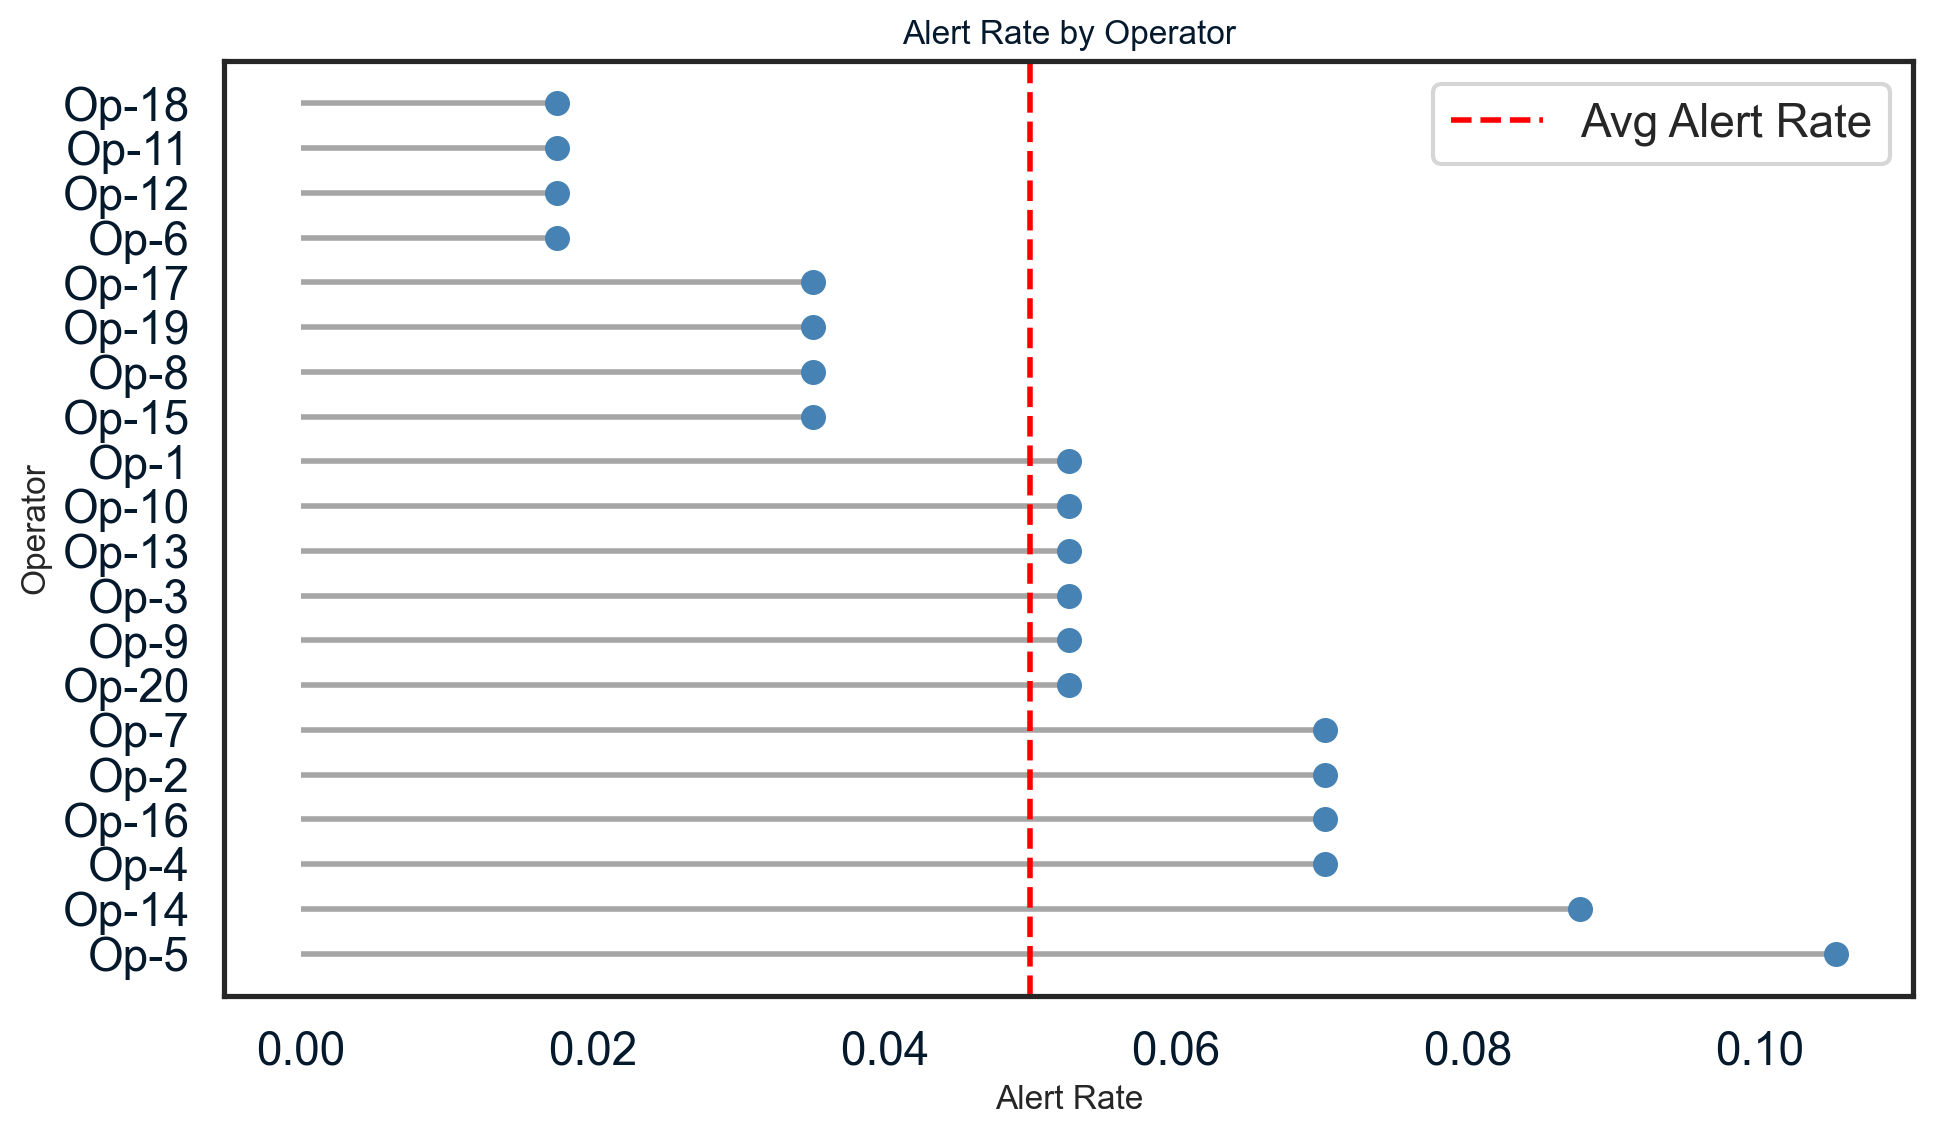

In [42]:
# Sort values for cleaner display
df_rates_sorted = df_operator_alerts.sort_values("alert_rate", ascending = False).copy()

# Plot
plt.figure(figsize = (10, 6))

# Lollipop stems
plt.hlines(y = df_sorted['operator'], xmin = 0, xmax = df_sorted['alert_rate'], color = 'gray', alpha = 0.7, linewidth = 2)

# Lollipop heads
plt.plot(df_sorted['alert_rate'], df_sorted['operator'], "o", markersize = 8, color = 'steelblue')

# Add reference line at avg_alert_rate (they're all the same, so just grab the first one)
avg_rate = df_sorted['avg_alert_rate'].iloc[0]
plt.axvline(x = avg_rate, color = 'red', linestyle = '--', linewidth = 2, label = 'Avg Alert Rate')

# Styling
plt.title("Alert Rate by Operator", fontsize = 12)
plt.xlabel("Alert Rate", fontsize = 12)
plt.ylabel("Operator", fontsize = 12)
plt.legend()
plt.tight_layout()
plt.show()

## 4.3 💬 Insight 3 Reflections
- **Most Common Pattern**:
    - The most common pattern observed is the variation in alert rates among different operators. This indicates that some operators have a higher tendency to generate alerts at a rate above the average. The `above_average` flag helps in identifying which operators have alert rates higher than the average, highlighting those who may need additional training or support.

- **Unexpected Pattern**:
    - An unexpected pattern is the presence of operators with alert rates significantly above the average, despite having a relatively low number of total alerts. This could be due to a small number of observations for those operators, making their alert rate appear disproportionately high. This pattern suggests that alert rate alone may not be a reliable indicator of performance without considering the context of the number of observations.

- **Real-World Meaning**:
    - In a real-world manufacturing environment, this insight can be used to identify operators who consistently perform above or below average in terms of alert generation rates. This information can be valuable for targeted training and process improvement initiatives, ensuring that operators who generate alerts at a higher rate receive the necessary support to improve their performance.

## 5. 🏁 Final Summary
- **Big Takeaways**:  
  - **Variation in Alert Rates**: There is a significant variation in alert rates among different operators, indicating that some operators may require additional training or support to align with the average performance.
  - **Alert Rate Context**: Operators with a low number of total alerts can still have high alert rates, suggesting that alert rate alone is not a sufficient performance indicator without considering the number of observations.
  - **Targeted Interventions**: Identifying operators with above-average alert rates can help in implementing targeted training and process improvements, ultimately enhancing overall operational efficiency.

- **Next Steps**:  
    - **Additional Plots**: Create a scatter plot of `alert_rate` vs. `alert_count` to visualize the relationship between the number of alerts and the alert rate for each operator. This can help identify outliers and patterns that may not be evident from summary statistics alone.
  - **Data Enrichment**: Collect more data points to increase the robustness of the analysis. This could include longer observation periods, additional operators, or more detailed logging of operational conditions.
  - **Performance Metrics**: Introduce additional performance metrics such as the time taken to resolve alerts, the severity of alerts, and the impact on production quality. This can provide a more comprehensive view of operator performance.